# CIFAR-10 을 이용한 CNN 구축

## 필요 라이브러리 로드

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
tf.__version__

'2.13.0'

## 로컬 GPU 장치 확인

In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3099450153131627737
 xla_global_id: -1]

## 데이터 로드

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [6]:
print([x.shape for x in [x_train, y_train, x_test, y_test]])

[(50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1)]


In [7]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## 데이터 탐색 및 시각화

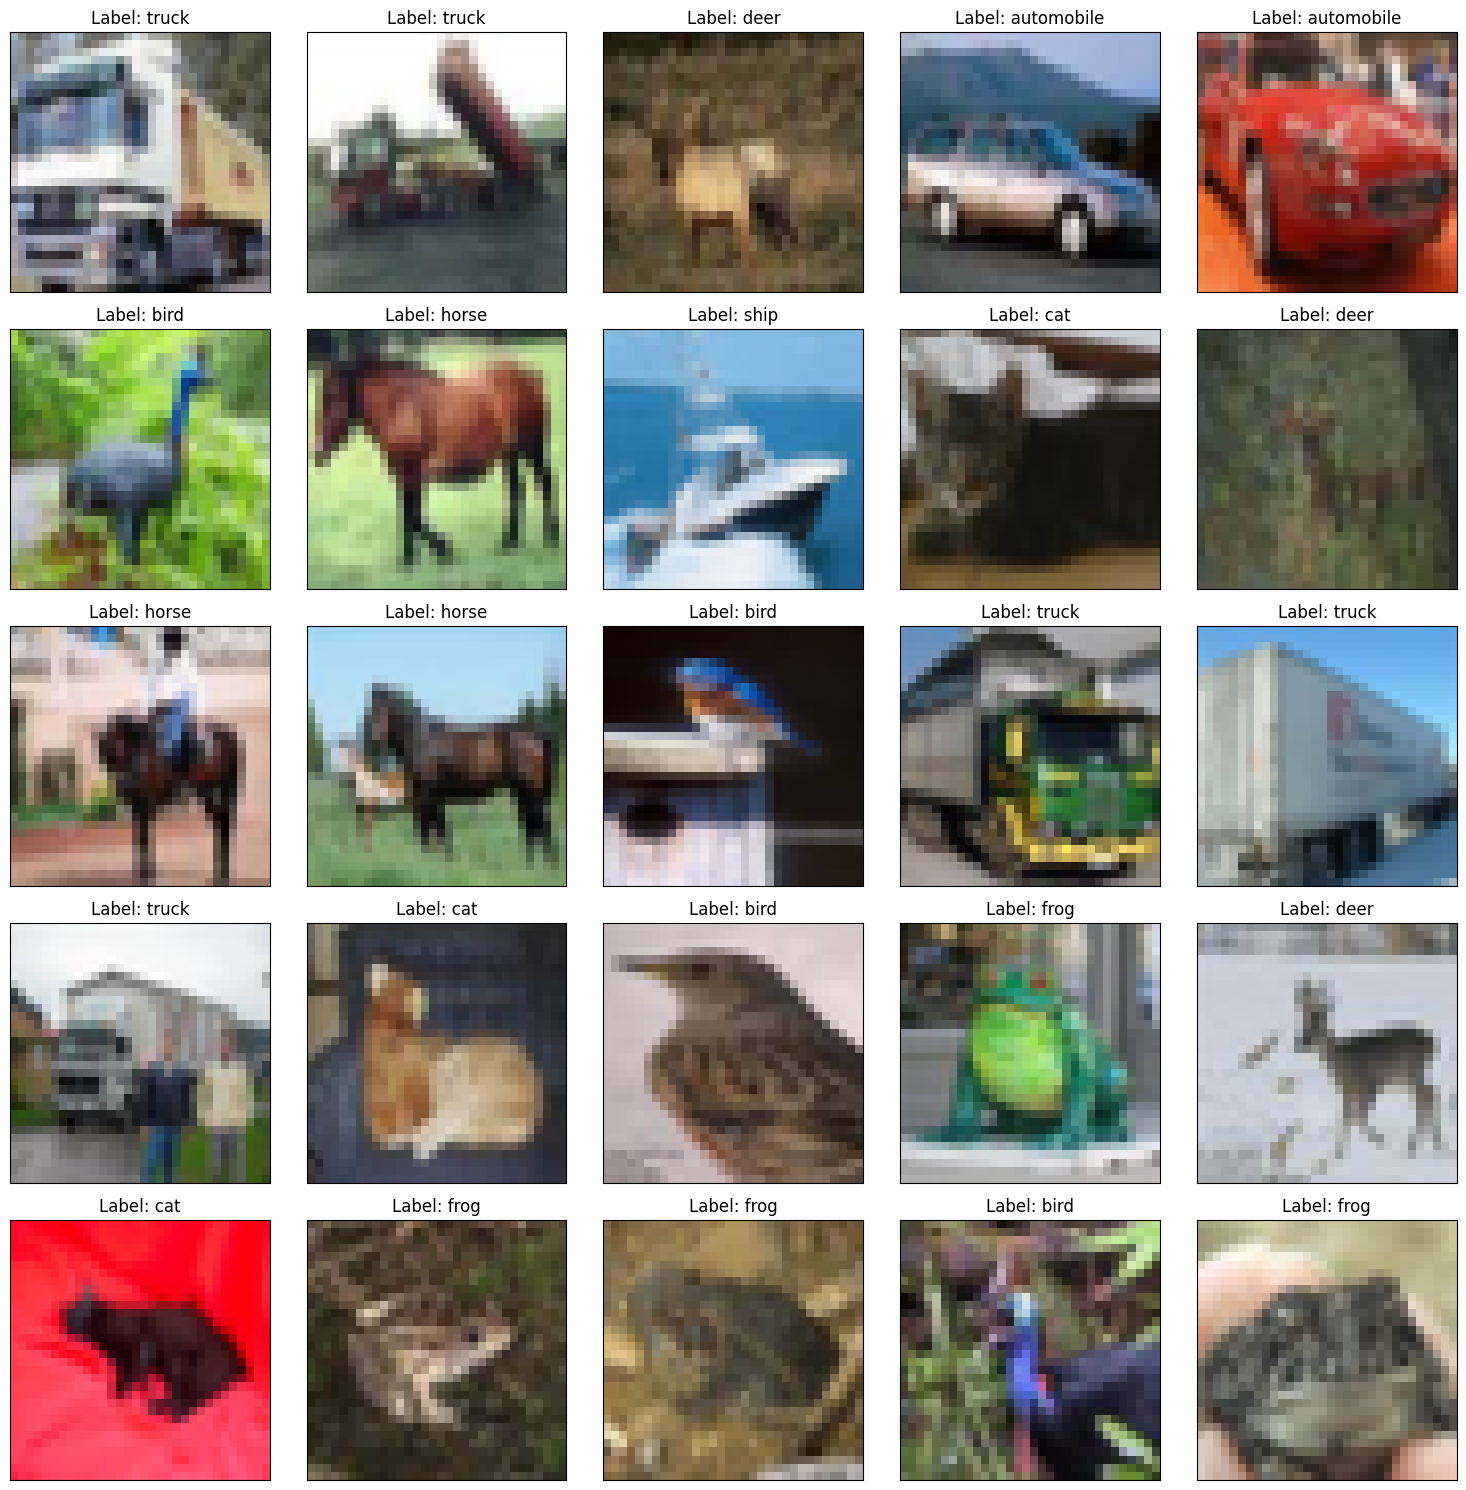

In [26]:
plt.figure(figsize=(15, 15))

for i in range(1, 26):
    plt.subplot(5,5,i)
    plt.imshow(x_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Label: {class_names[y_train[i][0]]}')

plt.tight_layout()
plt.show()

## 데이터 전처리

### Data Scaling

In [27]:
x_train[0][9]

array([[154, 120,  89],
       [154, 112,  77],
       [156, 114,  82],
       [140, 100,  65],
       [123,  89,  53],
       [125,  86,  50],
       [126,  86,  48],
       [127,  91,  52],
       [133,  97,  60],
       [132,  97,  68],
       [ 90,  60,  30],
       [ 63,  35,   9],
       [ 62,  33,  16],
       [ 70,  39,  20],
       [ 79,  50,  30],
       [103,  53,  26],
       [152,  70,  33],
       [148,  64,  37],
       [141,  79,  61],
       [121,  75,  57],
       [101,  58,  41],
       [ 96,  54,  33],
       [ 86,  48,  24],
       [ 75,  38,  21],
       [101,  63,  32],
       [136,  91,  53],
       [136,  92,  53],
       [134,  93,  50],
       [133,  93,  52],
       [132,  93,  52],
       [128,  86,  45],
       [133,  92,  55]], dtype=uint8)

In [8]:
x_train_scaled = x_train / 255.0
x_test_scaled = x_test / 255.0

In [29]:
x_train_scaled[0][9]

array([[0.60392157, 0.47058824, 0.34901961],
       [0.60392157, 0.43921569, 0.30196078],
       [0.61176471, 0.44705882, 0.32156863],
       [0.54901961, 0.39215686, 0.25490196],
       [0.48235294, 0.34901961, 0.20784314],
       [0.49019608, 0.3372549 , 0.19607843],
       [0.49411765, 0.3372549 , 0.18823529],
       [0.49803922, 0.35686275, 0.20392157],
       [0.52156863, 0.38039216, 0.23529412],
       [0.51764706, 0.38039216, 0.26666667],
       [0.35294118, 0.23529412, 0.11764706],
       [0.24705882, 0.1372549 , 0.03529412],
       [0.24313725, 0.12941176, 0.0627451 ],
       [0.2745098 , 0.15294118, 0.07843137],
       [0.30980392, 0.19607843, 0.11764706],
       [0.40392157, 0.20784314, 0.10196078],
       [0.59607843, 0.2745098 , 0.12941176],
       [0.58039216, 0.25098039, 0.14509804],
       [0.55294118, 0.30980392, 0.23921569],
       [0.4745098 , 0.29411765, 0.22352941],
       [0.39607843, 0.22745098, 0.16078431],
       [0.37647059, 0.21176471, 0.12941176],
       [0.

### Label One-Hot Encoding

In [30]:
print([x.shape for x in [y_train, y_test]])

[(50000, 1), (10000, 1)]


In [9]:
y_train_onehot = tf.keras.utils.to_categorical(y_train).astype('int')
y_test_onehot = tf.keras.utils.to_categorical(y_test).astype('int')

In [36]:
print([x.shape for x in [y_train_onehot, y_test_onehot]])

[(50000, 10), (10000, 10)]


### Data Shuffling 및 Batch

In [10]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train_scaled, y_train_onehot)).shuffle(10000).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((x_test_scaled, y_test_onehot)).shuffle(10000).batch(64)

In [11]:
for X, Y in train_ds.take(1):
    print(X.shape, Y.shape)

(64, 32, 32, 3) (64, 10)


## 모델링

### LeNet 모델 구성

In [39]:
model = tf.keras.models.Sequential()

# Convolutional Layer
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', input_shape=(32,32,3)))
model.add(tf.keras.layers.Activation(activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same'))
model.add(tf.keras.layers.Activation(activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same'))
model.add(tf.keras.layers.Activation(activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.2))

# Fully Connected Layer
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(units=10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 activation (Activation)     (None, 32, 32, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 16, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 activation_1 (Activation)   (None, 16, 16, 32)        0         
                                                        

In [40]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

### 모델 학습

In [41]:
history = model.fit(train_ds, epochs=5, validation_data=test_ds, shuffle=True)

Epoch 1/5
782/782 [==============================] - 32s 40ms/step - loss: 1.7242 - accuracy: 0.3641 - val_loss: 1.3943 - val_accuracy: 0.5049
Epoch 2/5
782/782 [==============================] - 32s 41ms/step - loss: 1.4015 - accuracy: 0.4918 - val_loss: 1.2013 - val_accuracy: 0.5778
Epoch 3/5
782/782 [==============================] - 36s 45ms/step - loss: 1.2719 - accuracy: 0.5438 - val_loss: 1.1173 - val_accuracy: 0.6074
Epoch 4/5
782/782 [==============================] - 35s 44ms/step - loss: 1.1919 - accuracy: 0.5753 - val_loss: 1.0309 - val_accuracy: 0.6345
Epoch 5/5
782/782 [==============================] - 38s 49ms/step - loss: 1.1244 - accuracy: 0.6009 - val_loss: 0.9973 - val_accuracy: 0.6480


### 모델 평가

In [42]:
model.metrics_names

['loss', 'accuracy']

In [43]:
scores = model.evaluate(test_ds)

157/157 [==============================] - 2s 11ms/step - loss: 0.9973 - accuracy: 0.6480


In [44]:
print(f'Model Loss=     {scores[0]:,.4f}')
print(f'Model Accuracy= {scores[1]:,.4f}')

Model Loss=     0.9973
Model Accuracy= 0.6480


### 모델 예측

In [46]:
y_pred = model.predict(x_test_scaled).argmax(axis=1)

313/313 [==============================] - 2s 6ms/step


In [49]:
y_pred.shape, y_test.shape

((10000,), (10000, 1))

In [50]:
y_true = y_test.ravel()

In [51]:
y_true.shape

(10000,)

### 모델 예측 평가

In [52]:
cm = confusion_matrix(y_true, y_pred)

In [53]:
cm

array([[663,  15,  49,  30,  23,   9,  20,  20, 121,  50],
       [ 18, 740,   5,   9,   0,   5,  23,   7,  21, 172],
       [ 75,   5, 366,  79, 161,  68, 162,  47,  18,  19],
       [ 11,   7,  36, 454,  88, 156, 147,  56,  13,  32],
       [ 21,   3,  43,  60, 582,  21, 139, 117,  11,   3],
       [  9,   3,  51, 209,  81, 488,  67,  74,   7,  11],
       [  3,   2,  16,  41,  40,  11, 859,  12,   7,   9],
       [ 11,   2,  16,  42,  69,  61,  28, 752,   3,  16],
       [ 58,  38,  13,  22,  11,   4,  16,   7, 794,  37],
       [ 37,  76,   3,  16,   4,   4,  28,  26,  24, 782]], dtype=int64)

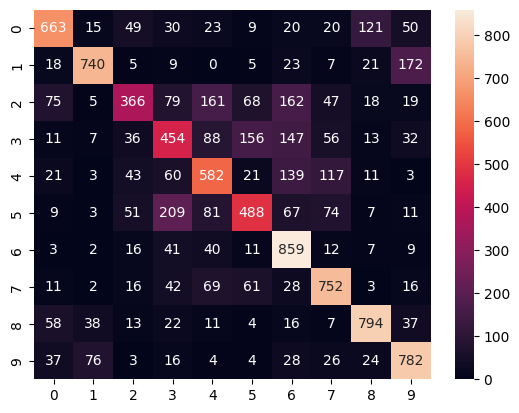

In [57]:
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [56]:
print(f'Accuracy  Score= {accuracy_score(y_true, y_pred):,.4f}')
print(f'Precision Score= {precision_score(y_true, y_pred, average="macro"):,.4f}')
print(f'Recall    Score= {recall_score(y_true, y_pred, average="macro"):,.4f}')
print(f'F1        Score= {f1_score(y_true, y_pred, average="macro"):,.4f}')

Accuracy  Score= 0.6480
Precision Score= 0.6506
Recall    Score= 0.6480
F1        Score= 0.6420


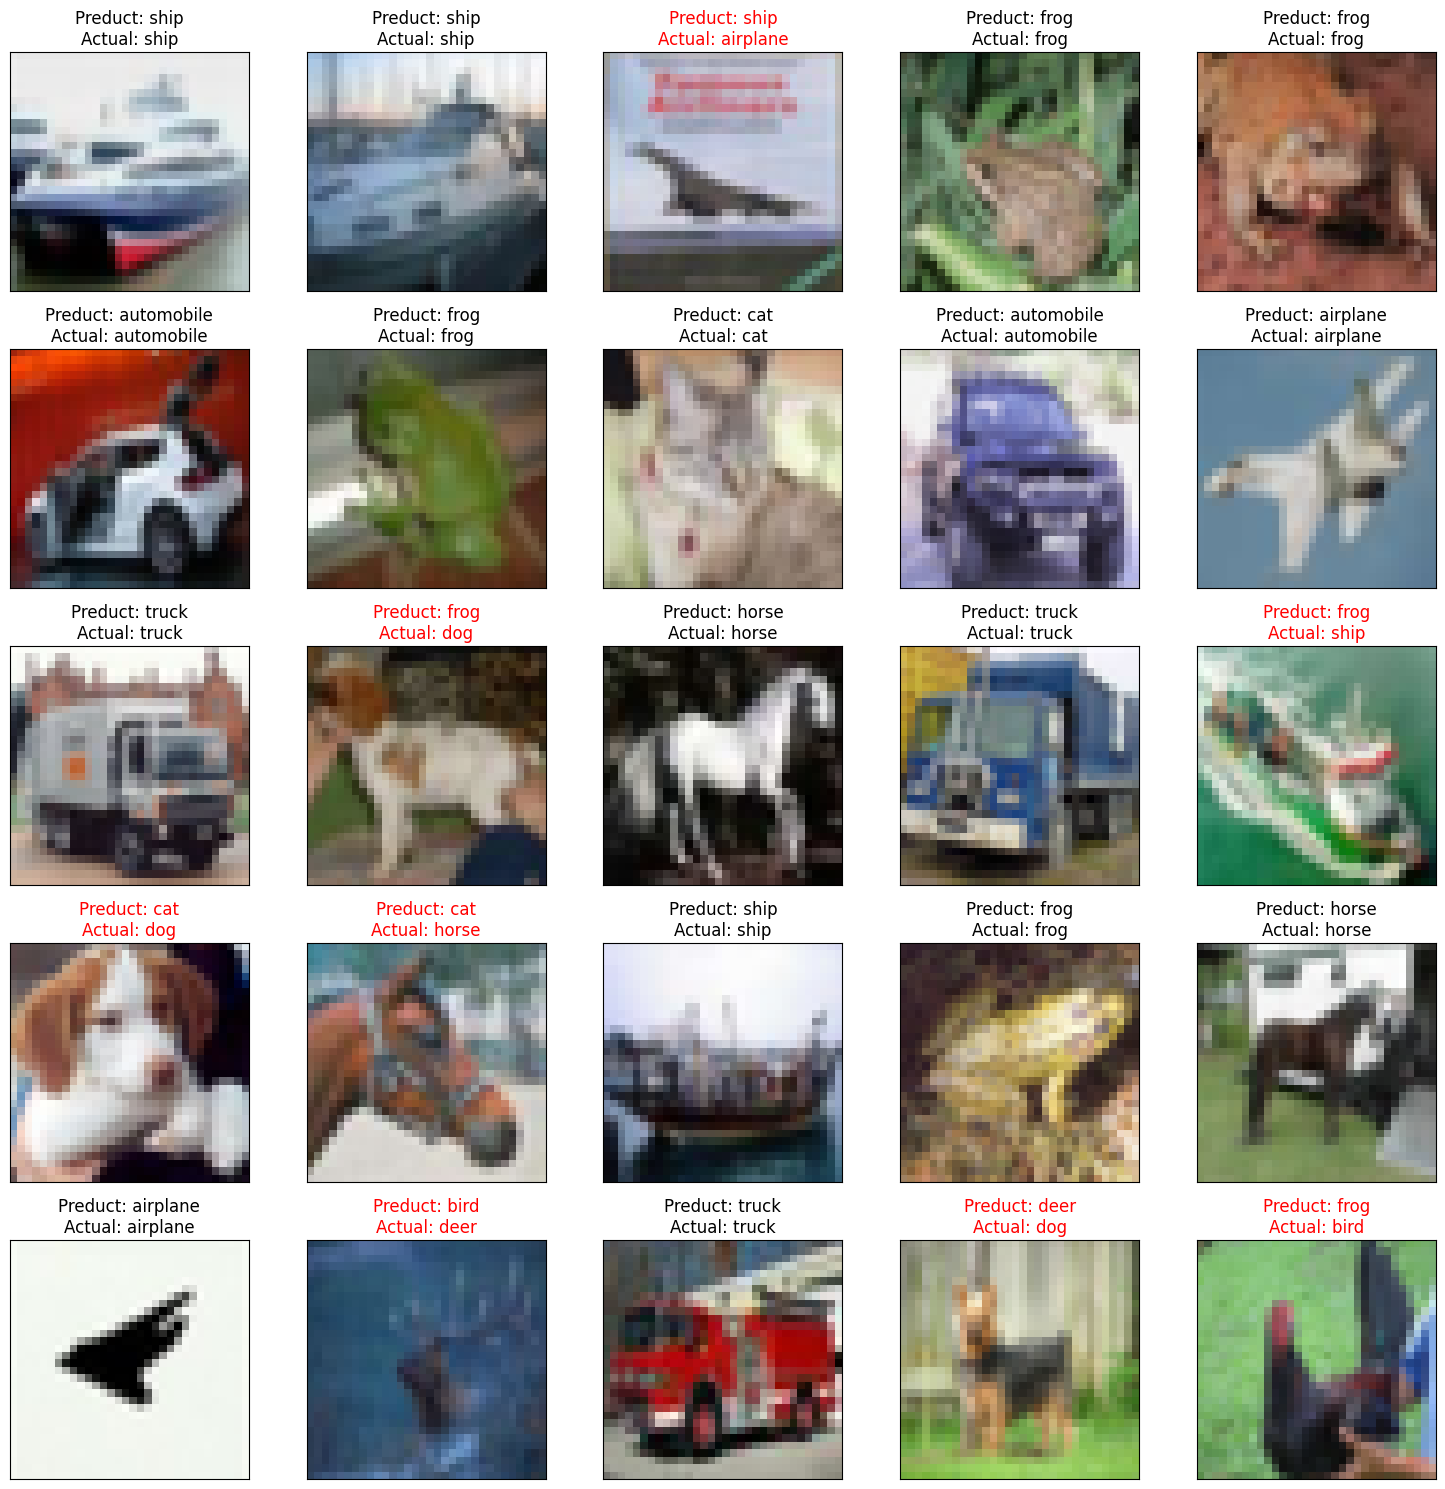

In [59]:
plt.figure(figsize=(15, 15))

for i in range(1, 26):
    plt.subplot(5,5,i)
    plt.imshow(x_test[i])
    plt.xticks([])
    plt.yticks([])

    color = 'black'
    if y_true[i] != y_pred[i]:
        color = 'red'
    plt.title(f'Preduct: {class_names[y_pred[i]]}\nActual: {class_names[y_true[i]]}', color=color)

plt.tight_layout()
plt.show()

# 실습 : Convolutional Layer 와 Pooling Layer 를  추가하고 Hyper-parameter 조정하여 성능 개선 혹은 epochs 늘려서 accuracy 향상 비교

## Convolutional Layer 및 Pooling Layer 추가

In [13]:
model = tf.keras.models.Sequential()

# Convolutional Layer
model.add(tf.keras.layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', input_shape=(32,32,3)))
model.add(tf.keras.layers.Activation(activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding='same'))
model.add(tf.keras.layers.Activation(activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same'))
model.add(tf.keras.layers.Activation(activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same'))
model.add(tf.keras.layers.Activation(activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.2))

# Fully Connected Layer
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=256, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 8)         224       
                                                                 
 activation (Activation)     (None, 32, 32, 8)         0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 8)         0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 16, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 16)        1168      
                                                                 
 activation_1 (Activation)   (None, 16, 16, 16)        0         
                                                        

## Hyper Parameter 조정

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

## Epoch 증가

In [15]:
history = model.fit(train_ds, epochs=10, validation_data=test_ds, shuffle=True)

Epoch 1/10
782/782 [==============================] - 23s 28ms/step - loss: 2.3034 - accuracy: 0.1076 - val_loss: 2.2954 - val_accuracy: 0.1531
Epoch 2/10
782/782 [==============================] - 24s 31ms/step - loss: 2.2813 - accuracy: 0.1345 - val_loss: 2.2532 - val_accuracy: 0.1961
Epoch 3/10
782/782 [==============================] - 27s 34ms/step - loss: 2.1620 - accuracy: 0.1904 - val_loss: 2.1049 - val_accuracy: 0.2302
Epoch 4/10
782/782 [==============================] - 30s 39ms/step - loss: 2.0783 - accuracy: 0.2193 - val_loss: 2.0778 - val_accuracy: 0.2319
Epoch 5/10
782/782 [==============================] - 25s 32ms/step - loss: 2.0561 - accuracy: 0.2324 - val_loss: 2.0614 - val_accuracy: 0.2408
Epoch 6/10
782/782 [==============================] - 25s 33ms/step - loss: 2.0406 - accuracy: 0.2407 - val_loss: 2.0459 - val_accuracy: 0.2512
Epoch 7/10
782/782 [==============================] - 25s 33ms/step - loss: 2.0299 - accuracy: 0.2448 - val_loss: 2.0286 - val_accuracy:

## 변경된 모델 평가

In [16]:
scores = model.evaluate(test_ds)

157/157 [==============================] - 1s 9ms/step - loss: 2.0117 - accuracy: 0.2662


In [17]:
print(f'Model Loss=     {scores[0]:,.4f}')
print(f'Model Accuracy= {scores[1]:,.4f}')

Model Loss=     2.0117
Model Accuracy= 0.2662


In [18]:
y_pred = model.predict(x_test_scaled).argmax(axis=1)

313/313 [==============================] - 2s 6ms/step


In [19]:
y_true = y_test.ravel()

In [20]:
cm = confusion_matrix(y_true, y_pred)

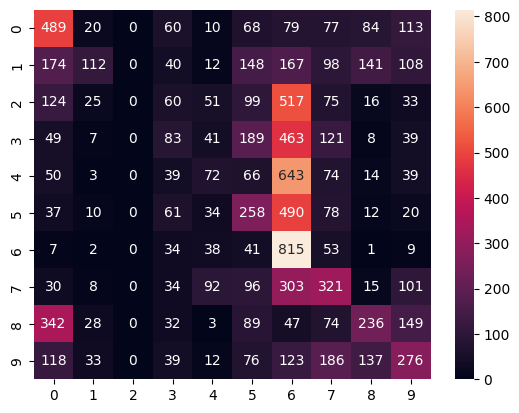

In [21]:
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [22]:
print(f'Accuracy  Score= {accuracy_score(y_true, y_pred):,.4f}')
print(f'Precision Score= {precision_score(y_true, y_pred, average="macro"):,.4f}')
print(f'Recall    Score= {recall_score(y_true, y_pred, average="macro"):,.4f}')
print(f'F1        Score= {f1_score(y_true, y_pred, average="macro"):,.4f}')

Accuracy  Score= 0.2662
Precision Score= 0.2561
Recall    Score= 0.2662
F1        Score= 0.2268


D:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


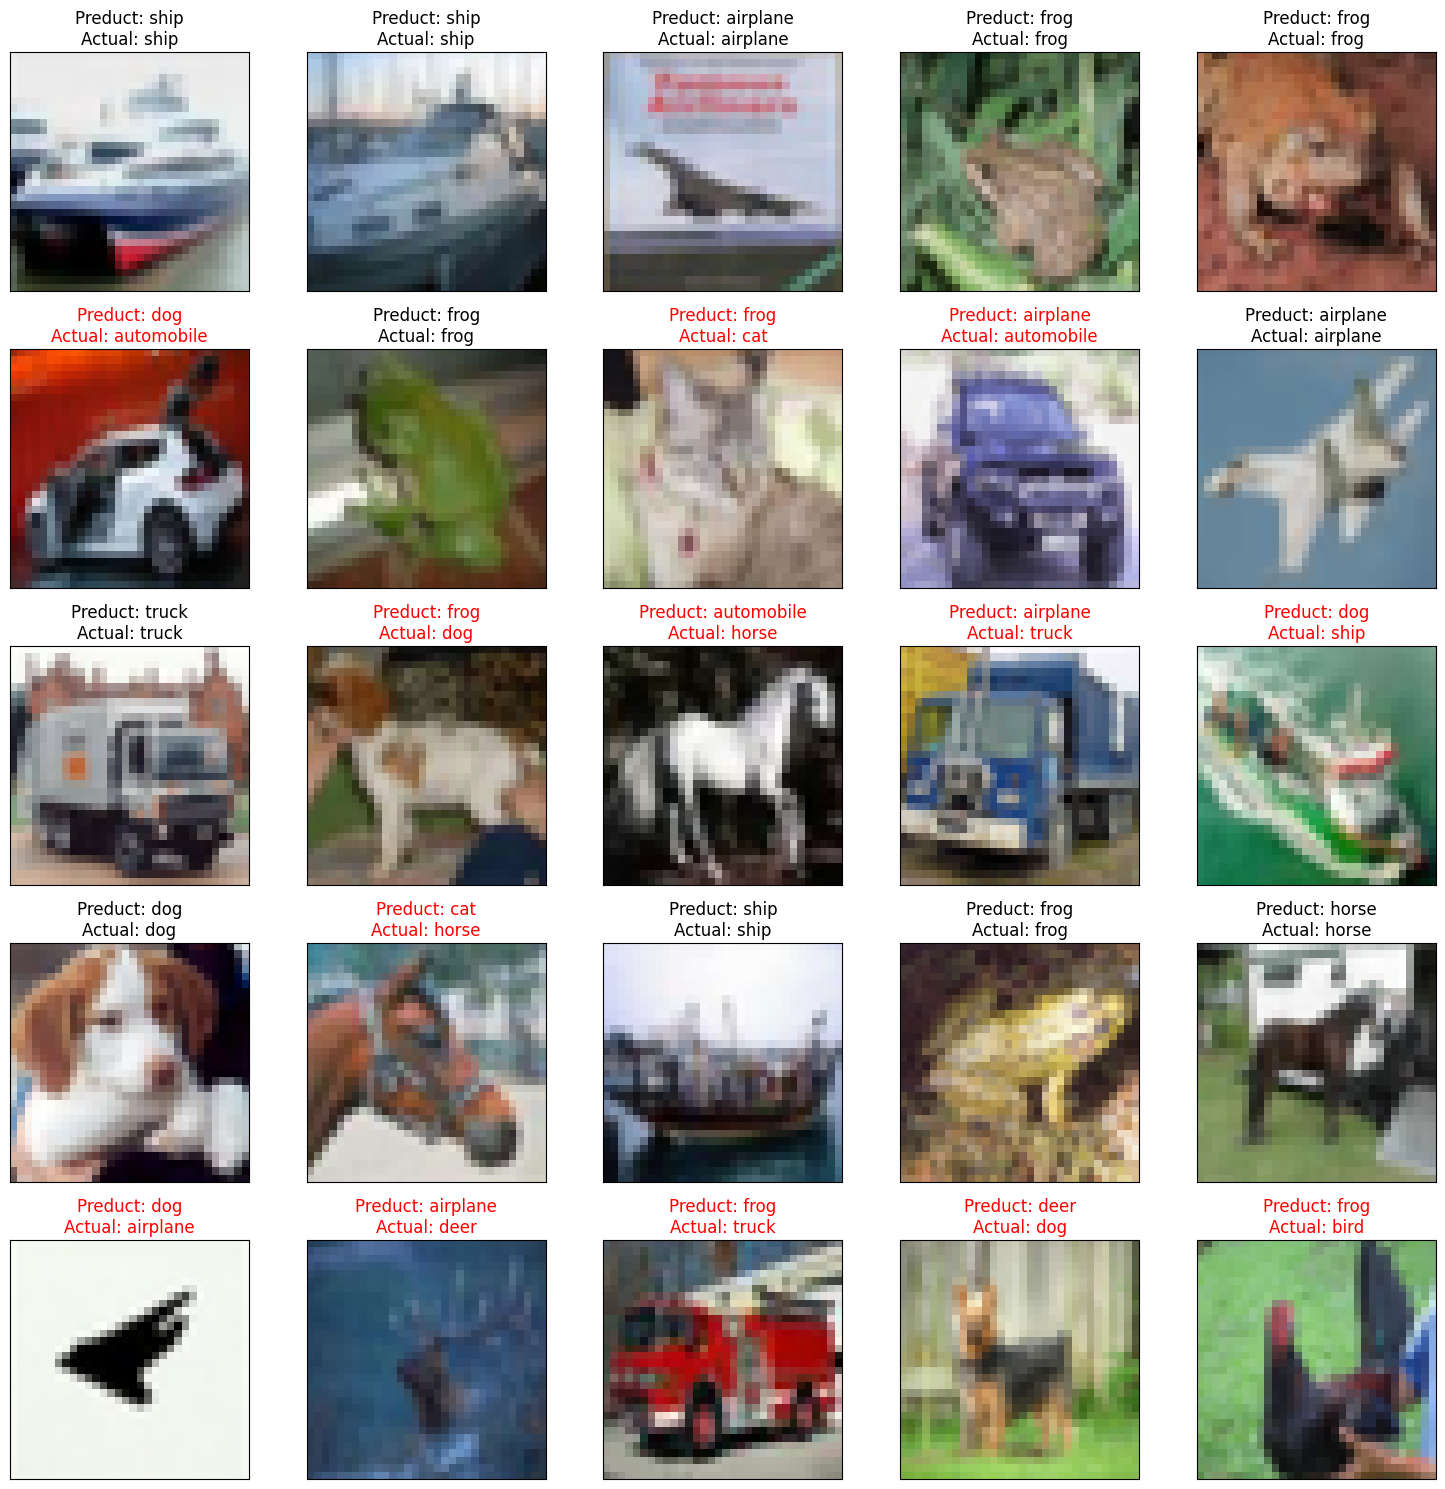

In [23]:
plt.figure(figsize=(15, 15))

for i in range(1, 26):
    plt.subplot(5,5,i)
    plt.imshow(x_test[i])
    plt.xticks([])
    plt.yticks([])

    color = 'black'
    if y_true[i] != y_pred[i]:
        color = 'red'
    plt.title(f'Preduct: {class_names[y_pred[i]]}\nActual: {class_names[y_true[i]]}', color=color)

plt.tight_layout()
plt.show()